In [ ]:
#  INSTALL & DOWNLOAD
# -------------------------------------------------------------
# (Run only once per session)
!pip install -q kaggle

# Make sure your Kaggle credentials are available:
import os, json, textwrap
os.environ['KAGGLE_USERNAME'] = 'YOUR_USERNAME'
os.environ['KAGGLE_KEY']      = 'YOUR_KEY'

!kaggle datasets download -d subhajournal/phishingemails -p /content
!unzip -o /content/phishingemails.zip -d /content/phishing_emails


Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
  0% 0.00/18.0M [00:00<?, ?B/s]
100% 18.0M/18.0M [00:00<00:00, 1.08GB/s]
Archive:  /content/phishingemails.zip
  inflating: /content/phishing_emails/Phishing_Email.csv  


In [ ]:
# LOAD DATA
import pandas as pd, numpy as np, re, string, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

FILE = '/content/phishing_emails/Phishing_Email.csv'
df = pd.read_csv(FILE)


# Display first rows & basic shape
print("Shape:", df.shape)
print(df.head(3), "\n")


Shape: (18650, 3)
   Unnamed: 0                                         Email Text  Email Type
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...  Safe Email
1           1  the other side of * galicismos * * galicismo *...  Safe Email
2           2  re : equistar deal tickets are you still avail...  Safe Email 



In [ ]:

# Drop the extra index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# ---------- 2. QUICK SANITY CHECK ----------
print(df.shape)


(18650, 2)


In [ ]:
print(df.head(3))

                                          Email Text  Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...  Safe Email
1  the other side of * galicismos * * galicismo *...  Safe Email
2  re : equistar deal tickets are you still avail...  Safe Email


In [ ]:

# Expecting columns: 'Email Text'  and  'Email Type'
assert {'Email Text','Email Type'}.issubset(df.columns), "Column names differ!"

In [ ]:

# ---------- TEXT CLEANING FUNCTION ----------
import re
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r'https?://\S+|www\.\S+', ' url ', txt)   # replace URLs
    txt = re.sub(r'[^a-z0-9\s]', ' ', txt)                # keep alphanum+space
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt

df['text']  = df['Email Text'].apply(clean_text)

In [ ]:

# Encode labels → 0 = safe, 1 = phishing
label_map   = {'Safe Email':0, 'Phishing Email':1, 'Phishing':1, 'Legitimate':0}
df['label'] = df['Email Type'].map(label_map)

In [ ]:

# ---------- DROP MISSING & SPLIT ----------
df.dropna(subset=['text','label'], inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

print(f"train: {len(X_train)}  test: {len(X_test)}")

train: 14920  test: 3730


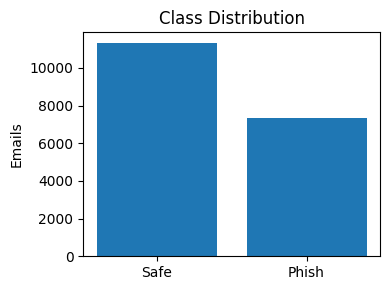

In [ ]:

# ---------- SIMPLE EDA PLOTS ----------
# A. class counts
counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(4,3))
plt.bar(['Safe','Phish'], counts)
plt.title('Class Distribution')
plt.ylabel('Emails')
plt.tight_layout(); plt.show()


count    1.865000e+04
mean     4.170927e+02
std      1.830559e+04
min      0.000000e+00
50%      1.360000e+02
90%      5.940000e+02
95%      9.615500e+02
99%      2.433040e+03
99.9%    1.102661e+04
max      2.498671e+06
Name: text, dtype: float64


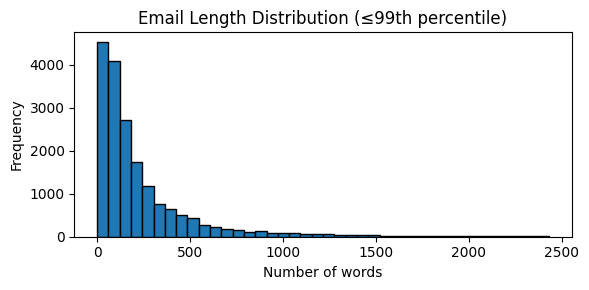

In [ ]:
lengths = df['text'].str.split().apply(len)
print(lengths.describe(percentiles=[.9, .95, .99, .999]))
#  message lengths
p99 = lengths.quantile(0.99)
trimmed = lengths[lengths <= p99]

plt.figure(figsize=(6,3))
plt.hist(trimmed, bins=40, edgecolor='black')
plt.title('Email Length Distribution (≤99th percentile)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

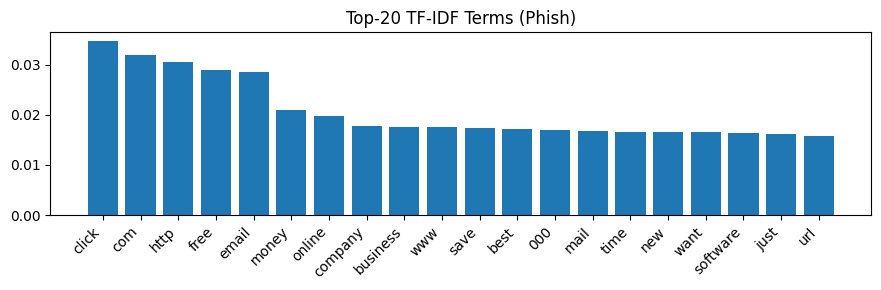

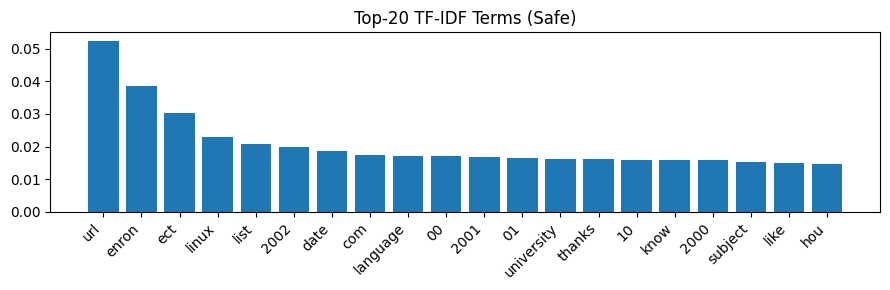

In [ ]:

# Top-20 TF-IDF words for each class
tfidf_all = TfidfVectorizer(stop_words='english', max_features=3000)
X_all     = tfidf_all.fit_transform(df['text'])
terms     = np.array(tfidf_all.get_feature_names_out())
for cls,name in [(1,'Phish'),(0,'Safe')]:
    idx  = np.where(df['label']==cls)[0]
    mean = np.asarray(X_all[idx].mean(axis=0)).ravel()
    top  = mean.argsort()[-20:][::-1]
    plt.figure(figsize=(9,3))
    plt.bar(range(20), mean[top]); plt.xticks(range(20), terms[top], rotation=45, ha='right')
    plt.title(f'Top-20 TF-IDF Terms ({name})'); plt.tight_layout()
    plt.savefig(f'/content/top20_{name.lower()}.png'); plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import re, string, seaborn as sns
import warnings
warnings.filterwarnings(
    "ignore",
    message="Clustering metrics expects discrete values",
    module="sklearn.metrics.cluster"
)

# **Model Development**

## **FEATURE SELECTION (chi-square & mutual information)**

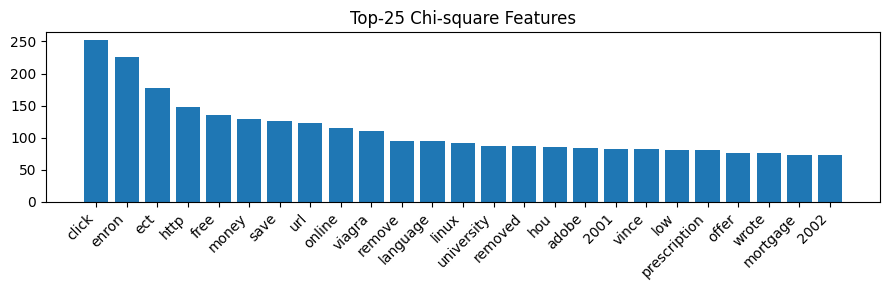

In [ ]:
X_train_vec = tfidf_all.transform(X_train)

# Chi-square
chi_scores, _ = chi2(X_train_vec, y_train)
chi_top = np.argsort(chi_scores)[-25:][::-1]
plt.figure(figsize=(9,3))
plt.bar(range(25), chi_scores[chi_top])
plt.xticks(range(25), terms[chi_top], rotation=45, ha='right')
plt.title('Top-25 Chi-square Features'); plt.tight_layout()
plt.savefig('/content/top25_chi2.png'); plt.show()

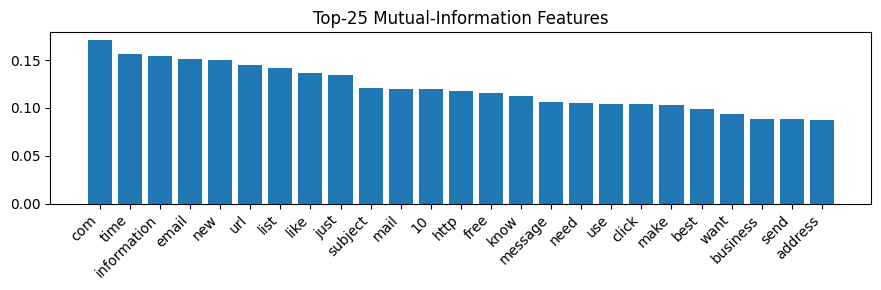

In [ ]:

# Mutual Information
mi_scores = mutual_info_classif(X_train_vec, y_train, discrete_features=True)
mi_top    = np.argsort(mi_scores)[-25:][::-1]
plt.figure(figsize=(9,3))
plt.bar(range(25), mi_scores[mi_top])
plt.xticks(range(25), terms[mi_top], rotation=45, ha='right')
plt.title('Top-25 Mutual-Information Features'); plt.tight_layout()


## **BASELINE MODEL (TF-IDF + Logistic Regression)**

Accuracy: 0.9584


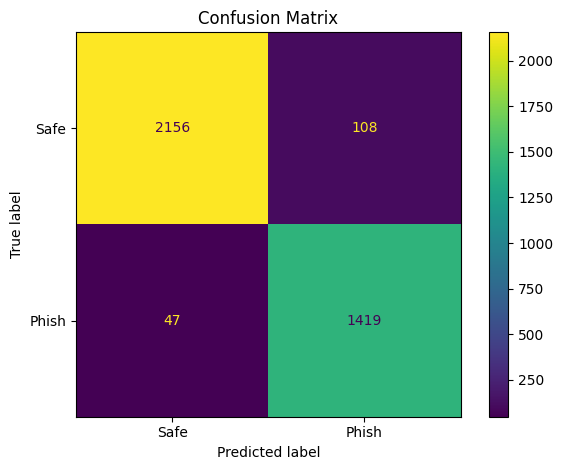

In [ ]:


lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_vec, y_train)

# Evaluate
X_test_vec = tfidf_all.transform(X_test)
y_pred     = lr.predict(X_test_vec)
acc        = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Safe','Phish']).plot(values_format='d')
plt.title('Confusion Matrix'); plt.tight_layout()
